In [2]:
import os
import math
import string
import random
import time
import pandas as pd

import wandb
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm
import cv2
import numpy as np
from torchvision import transforms

# CONFIG

In [3]:
class Hparams():
    def __init__(self):

        # SETS OF CHARACTERS
        self.chars = []
        # CHARS TO REMOVE
        self.del_sym = []
            
        self.lr = 0.001
        self.batch_size = 64
        self.hidden = 512
        self.enc_layers = 2
        self.dec_layers = 2
        self.nhead = 4
        self.dropout = 0.0
        
        # IMAGE SIZE
        self.width = 256
        self.height = 64


random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

hp = Hparams()

In [4]:
pd.options.display.max_rows = 10

df = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_train_v2.csv')
print(df) 

                FILENAME       IDENTITY
0        TRAIN_00001.jpg      BALTHAZAR
1        TRAIN_00002.jpg          SIMON
2        TRAIN_00003.jpg          BENES
3        TRAIN_00004.jpg        LA LOVE
4        TRAIN_00005.jpg         DAPHNE
...                  ...            ...
330956  TRAIN_330957.jpg          LENNY
330957  TRAIN_330958.jpg        TIFFANY
330958  TRAIN_330959.jpg  COUTINHO DESA
330959  TRAIN_330960.jpg         MOURAD
330960  TRAIN_330961.jpg        HELOISE

[330961 rows x 2 columns]


In [5]:
def text_to_labels(s, char2idx):
    return [char2idx['SOS']] + [char2idx[i] for i in s if i in char2idx.keys()] + [char2idx['EOS']]

In [6]:
def process_data(image_dir, labels_dir, ignore=[]):

    chars = []
    img2label = dict()

    raw = open(labels_dir, 'r', encoding='utf-8').read()
    temp = raw.split('\n')
    for t in temp:
        try:
            x = t.split(',')
            flag = False
            for item in ignore:
                if item in x[1]:
                    flag = True #check for puncuation and other non-alphanumerics
            if flag == False:
                img2label[image_dir + x[0]] = x[1]
                for char in x[1]:
                    if char not in chars:
                        chars.append(char) #list of all occurred words
        except:
            print('ValueError:', x)
            pass

    all_labels = sorted(list(set(list(img2label.values()))))
    chars.sort()
    chars = ['PAD', 'SOS'] + chars + ['EOS']

    return img2label, chars, all_labels

In [7]:
class TextCollate():
    def __call__(self, batch):
        x_padded = []
        max_y_len = max([i[1].size(0) for i in batch])
        y_padded = torch.LongTensor(max_y_len, len(batch))
        y_padded.zero_()

        for i in range(len(batch)):
            x_padded.append(batch[i][0].unsqueeze(0))
            y = batch[i][1]
            y_padded[:y.size(0), i] = y

        x_padded = torch.cat(x_padded)
        return x_padded, y_padded

In [8]:
def labels_to_text(s, idx2char):

    S = "".join([idx2char[i] for i in s])
    if S.find('EOS') == -1:
        return S
    else:
        return S[:S.find('EOS')]

In [9]:
def char_error_rate(p_seq1, p_seq2):
    p_vocab = set(p_seq1 + p_seq2)
    p2c = dict(zip(p_vocab, range(len(p_vocab))))
    c_seq1 = [chr(p2c[p]) for p in p_seq1]
    c_seq2 = [chr(p2c[p]) for p in p_seq2]
    return editdistance.eval(''.join(c_seq1),
                             ''.join(c_seq2)) / max(len(c_seq1), len(c_seq2))


In [10]:
def process_image(img):
    w, h, _ = img.shape
    new_w = hp.height
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h, _ = img.shape

    img = img.astype('float32')

    new_h = hp.width
    if h < new_h:
        add_zeros = np.full((w, new_h - h, 3), 255)
        img = np.concatenate((img, add_zeros), axis=1)

    if h > new_h:
        img = cv2.resize(img, (new_h, new_w))

    return img

def generate_data(img_paths):
    data_images = []
    for path in tqdm(img_paths):
        img = cv2.imread(path)
        try:
            img = process_image(img)
            data_images.append(img.astype('uint8'))
        except:
            print('ERROR:',path)
            #img = process_image(img)
    return data_images

# LOAD AND PREPARE TRAIN DATASET

In [11]:
class TextLoader(torch.utils.data.Dataset):
    def __init__(self, images_name, labels, char2idx, idx2char, eval=False):
        self.images_name = images_name
        self.labels = labels
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.eval = eval
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            #p.torch_transform(),  # random distortion and shear
            # transforms.Resize((int(hp.height *1.05), int(hp.width *1.05))),
            # transforms.RandomCrop((hp.height, hp.width)),
            # transforms.ColorJitter(contrast=(0.5,1),saturation=(0.5,1)),
            #transforms.RandomRotation(degrees=(-9, 9), fill=255),
            # transforms.RandomAffine(10 ,None ,[0.6 ,1] ,3 ,fillcolor=255),
            transforms.transforms.GaussianBlur(3, sigma=(0.1, 1.9)),
            transforms.ToTensor()
        ])

    def _transform(self, X):
        j = np.random.randint(0, 3, 1)[0]
        if j == 0:
            return self.transform(X)
        if j == 1:
            return tt(ld(vignet(X)))
        if j == 2:
            return tt(ld(un(X)))
        

    def __getitem__(self, index):
        img = self.images_name[index]
        if not self.eval:
            img = self.transform(img)
            img = img / img.max()
            img = img ** (random.random() * 0.7 + 0.6)
        else:
            img = np.transpose(img, (2, 0, 1))
            img = img / img.max()

        label = text_to_labels(self.labels[index], self.char2idx)
        return (torch.FloatTensor(img), torch.LongTensor(label))

    def __len__(self):
        return len(self.labels)

In [12]:
img2label, chars, all_words = process_data("../input/handwriting-recognition/train_v2/train/", "../input/handwriting-recognition/written_name_train_v2.csv")
X_train, y_train = [], []
hp.chars = chars
char2idx = {char: idx for idx, char in enumerate(hp.chars)}
print(char2idx)
idx2char = {idx: char for idx, char in enumerate(hp.chars)}

ValueError: ['']
{'PAD': 0, 'SOS': 1, ' ': 2, "'": 3, '-': 4, 'A': 5, 'B': 6, 'C': 7, 'D': 8, 'E': 9, 'F': 10, 'G': 11, 'H': 12, 'I': 13, 'J': 14, 'K': 15, 'L': 16, 'M': 17, 'N': 18, 'O': 19, 'P': 20, 'Q': 21, 'R': 22, 'S': 23, 'T': 24, 'U': 25, 'V': 26, 'W': 27, 'X': 28, 'Y': 29, 'Z': 30, '`': 31, 'a': 32, 'b': 33, 'c': 34, 'e': 35, 'f': 36, 'g': 37, 'h': 38, 'i': 39, 'l': 40, 'm': 41, 'n': 42, 'o': 43, 'p': 44, 'r': 45, 's': 46, 't': 47, 'u': 48, 'v': 49, 'y': 50, 'z': 51, 'EOS': 52}


In [12]:
items = list(img2label.items())[60000:130000] # a dataset is too big for size of 256x64, so, it needs to be trained by part.
random.shuffle(items)
for i, item in enumerate(items):
    X_train.append(item[0])
    y_train.append(item[1])

X_train = generate_data(X_train)
train_dataset = TextLoader(X_train, y_train, char2idx, idx2char, eval=False)
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True,
                                           batch_size=4, pin_memory=True,
                                           drop_last=True, collate_fn=TextCollate())
epochs, best_eval_loss_cer = 0, float('inf')

100%|██████████| 70000/70000 [05:43<00:00, 203.85it/s]


In [16]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# print("The images in the dataset look like")
# Set the number of examples to display
num_examples_to_display = 8

# Initialize the list to hold examples and a counter
examples = []
idx = 0

# Loop through the train loader to get the first batch
for batch in train_loader:
    img = batch[0]
    examples.append(img)
    idx += 1
    if idx == num_examples_to_display:
        break

# Set the figure size
fig = plt.figure(figsize=(20, 10))

# Calculate the number of rows and columns
rows = num_examples_to_display // 4 + (num_examples_to_display % 4 > 0)
columns = 4

# Loop through the examples and add subplots
for j, exp in enumerate(examples):
    ax = fig.add_subplot(rows, columns, j + 1)
    ax.imshow(exp[0].permute(1, 2, 0))  # Permute dimensions for correct display
    ax.axis('off')  # Hide axes for a cleaner look

# Display the plot
plt.tight_layout()
plt.show()


# TRANSFORMER MODEL

In [14]:
from torchvision import models
class TransformerModel(nn.Module):
    def __init__(self, bb_name, outtoken, hidden, enc_layers=1, dec_layers=1, nhead=1, dropout=0.1, pretrained=False):
        super(TransformerModel, self).__init__()
        self.backbone = models.__getattribute__(bb_name)(pretrained=pretrained)
        self.backbone.fc = nn.Conv2d(2048, int(hidden/2), 1)

        self.pos_encoder = PositionalEncoding(hidden, dropout)
        self.decoder = nn.Embedding(outtoken, hidden)
        self.pos_decoder = PositionalEncoding(hidden, dropout)
        self.transformer = nn.Transformer(d_model=hidden, nhead=nhead, num_encoder_layers=enc_layers,
                                          num_decoder_layers=dec_layers, dim_feedforward=hidden * 4, dropout=dropout,
                                          activation='relu')

        self.fc_out = nn.Linear(hidden, outtoken)
        self.src_mask = None
        self.trg_mask = None
        self.memory_mask = None
        
        print('backbone: {}'.format(type(self.backbone)))
        print('layers: {}'.format(enc_layers))
        print('heads: {}'.format(nhead))
        print('dropout: {}'.format(dropout))

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), 1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask

    def make_len_mask(self, inp):
        return (inp == 0).transpose(0, 1)

    def forward(self, src, trg):
        '''
        params
        ---
        src : Tensor [64, 3, 64, 256] : [B,C,H,W]
            B - batch, C - channel, H - height, W - width
        trg : Tensor [13, 64] : [L,B]
            L - max length of label
        '''
        if self.trg_mask is None or self.trg_mask.size(0) != len(trg):
            self.trg_mask = self.generate_square_subsequent_mask(len(trg)).to(trg.device) 
        x = self.backbone.conv1(src)

        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x) # [64, 2048, 2, 8] : [B,C,H,W]
            
        x = self.backbone.fc(x) # [64, 256, 2, 8] : [B,C,H,W]
        x = x.permute(0, 3, 1, 2) # [64, 8, 256, 2] : [B,W,C,H]
        x = x.flatten(2) # [64, 8, 512] : [B,W,CH]
        x = x.permute(1, 0, 2) # [8, 64, 512] : [W,B,CH]
        
        src_pad_mask = self.make_len_mask(x[:, :, 0])
        src = self.pos_encoder(x) # [8, 64, 512]
        trg_pad_mask = self.make_len_mask(trg)
        trg = self.decoder(trg)
        trg = self.pos_decoder(trg)

        output = self.transformer(src, trg, src_mask=self.src_mask, tgt_mask=self.trg_mask,
                                  memory_mask=self.memory_mask,
                                  src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=trg_pad_mask,
                                  memory_key_padding_mask=src_pad_mask) # [13, 64, 512] : [L,B,CH]
        output = self.fc_out(output) # [13, 64, 92] : [L,B,H]

        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.scale = nn.Parameter(torch.ones(1))

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(
            0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.scale * self.pe[:x.size(0), :]
        return self.dropout(x) 

# TRAIN

In [15]:
def train(model, optimizer, criterion, iterator):
    model.train()
    epoch_loss = 0
    counter = 0
    for src, trg in iterator:
        counter += 1
        if counter % 5000 == 0:
            print('[', counter, '/', len(iterator), ']')
        if torch.cuda.is_available():
          src, trg = src.cuda(), trg.cuda()

        optimizer.zero_grad()
        output = model(src, trg[:-1, :])

        loss = criterion(output.view(-1, output.shape[-1]), torch.reshape(trg[1:, :], (-1,)))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [16]:
model = TransformerModel('resnet50', len(hp.chars), hidden=hp.hidden, enc_layers=2, dec_layers=2,   
                         nhead=4, dropout=0.0).to(device)

backbone: <class 'torchvision.models.resnet.ResNet'>
layers: 2
heads: 4
dropout: 0.0


load checkout

In [17]:
# model.load_state_dict(torch.load('/kaggle/input/resnet50-transformer-handwriting-recognition/ocr_model.pt'))

In [18]:
import torch

optimizer = optim.Adam(model.parameters(), lr=0.00004)
criterion = nn.CrossEntropyLoss(ignore_index=char2idx['PAD'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
epochs = 10

for epoch in range(epochs):
    epoch_loss = train(model, optimizer, criterion, train_loader)
    
    print(f'--- epoch {epoch+1} ---')
    print(f'loss: {epoch_loss}')
    
    # Save the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        model_path = f'model_epoch_{epoch+1}.pth'
        torch.save(model.state_dict(), model_path)
        print(f'Model saved at {model_path}')


[ 5000 / 17500 ]
[ 10000 / 17500 ]
[ 15000 / 17500 ]
--- epoch 1 ---
loss: 1.840841367803301
[ 5000 / 17500 ]
[ 10000 / 17500 ]
[ 15000 / 17500 ]
--- epoch 2 ---
loss: 1.6047088715655462
Model saved at model_epoch_2.pth
[ 5000 / 17500 ]
[ 10000 / 17500 ]
[ 15000 / 17500 ]
--- epoch 3 ---
loss: 1.5213157248616218
[ 5000 / 17500 ]
[ 10000 / 17500 ]
[ 15000 / 17500 ]
--- epoch 4 ---
loss: 1.46936337621212
Model saved at model_epoch_4.pth
[ 5000 / 17500 ]
[ 10000 / 17500 ]
[ 15000 / 17500 ]
--- epoch 5 ---
loss: 1.3727106296573366
[ 5000 / 17500 ]
[ 10000 / 17500 ]
[ 15000 / 17500 ]
--- epoch 6 ---
loss: 1.024600793159008
Model saved at model_epoch_6.pth
[ 5000 / 17500 ]
[ 10000 / 17500 ]
[ 15000 / 17500 ]
--- epoch 7 ---
loss: 0.7978576182703887
[ 5000 / 17500 ]
[ 10000 / 17500 ]
[ 15000 / 17500 ]
--- epoch 8 ---
loss: 0.5899670341834425
Model saved at model_epoch_8.pth
[ 5000 / 17500 ]
[ 10000 / 17500 ]
[ 15000 / 17500 ]
--- epoch 9 ---
loss: 0.44887991555838713
[ 5000 / 17500 ]
[ 10000 

it is recommended to train for at least 10 epochs 

In [19]:
torch.save(model.state_dict(), './ocr_model.pt')

# TEST

In [20]:
import gc
del X_train, y_train, train_loader, train_dataset
gc.collect()

23

In [21]:
img2label, chars, all_words = process_data(
    "../input/handwriting-recognition/test_v2/test/",
    "../input/handwriting-recognition/written_name_test_v2.csv"
)
X_test, y_test = [], []
items = list(img2label.items())[1:] # skip header
for i, item in enumerate(items):
    X_test.append(item[0])
    y_test.append(item[1])

X_test = generate_data(X_test)

ValueError: ['']


100%|██████████| 41370/41370 [06:02<00:00, 114.09it/s]


In [22]:
test_dataset = TextLoader(X_test, y_test, char2idx, idx2char, eval=False)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True,
                                           batch_size=1, pin_memory=True,
                                           drop_last=True, collate_fn=TextCollate())

In [23]:
model.load_state_dict(torch.load('/kaggle/working/ocr_model.pt'))

<All keys matched successfully>

In [24]:
preds = []
for src, trg in tqdm(test_loader):
    #src = torch.FloatTensor(img).unsqueeze(0)
    if torch.cuda.is_available():
        src = src.cuda()
    x = model.backbone.conv1(src)
    x = model.backbone.bn1(x)
    x = model.backbone.relu(x)
    x = model.backbone.maxpool(x)

    x = model.backbone.layer1(x)
    x = model.backbone.layer2(x)
    x = model.backbone.layer3(x)
    x = model.backbone.layer4(x)

    x = model.backbone.fc(x)
    x = x.permute(0, 3, 1, 2).flatten(2).permute(1, 0, 2)
    memory = model.transformer.encoder(model.pos_encoder(x))

    p_values = 1
    out_indexes = [char2idx['SOS'], ]
    for i in range(100):
        trg_tensor = torch.LongTensor(out_indexes).unsqueeze(1).to(device)
        output = model.fc_out(model.transformer.decoder(model.pos_decoder(model.decoder(trg_tensor)), memory))

        out_token = output.argmax(2)[-1].item()
        p_values = p_values * torch.sigmoid(output[-1, 0, out_token]).item()
        out_indexes.append(out_token)
        if out_token == char2idx['EOS']:
            break

    pred = labels_to_text(out_indexes[1:], idx2char)
    true = ''.join([ idx2char[ch] for ch in trg.transpose(0,1)[0].numpy()])[3:-3]
    preds.append({'predicted_transcript': pred, 'true_transcript' : true, 'p_values': p_values})

100%|██████████| 41370/41370 [34:09<00:00, 20.18it/s]


In [25]:
!pip install editdistance

     |████████████████████████████████| 282 kB 6.2 MB/s eta 0:00:01


In [26]:
import editdistance
N = len(preds)
wer = 0
cer = 0
for item in preds:
    if item['true_transcript'] != item['predicted_transcript']:
        wer += 1
        cer += char_error_rate(item['predicted_transcript'], item['true_transcript'])

character_accuracy = 1 - (cer / N)
string_accuracy = 1 - (wer / N)

print(character_accuracy)
print(string_accuracy)

0.7804006535881151
0.44445250181290785


## Inference on one custom image

In [28]:
model = TransformerModel('resnet50', len(hp.chars), hidden=hp.hidden, enc_layers=2, dec_layers=2,   
                         nhead=4, dropout=0.0).to(device)
model.load_state_dict(torch.load('/kaggle/working/model_epoch_10.pth'))

backbone: <class 'torchvision.models.resnet.ResNet'>
layers: 2
heads: 4
dropout: 0.0


<All keys matched successfully>

In [41]:
def inference(model: nn.Module, image_path: str) -> str:
    img = Image.open(image_path)

    # Apply the transform to the image
    transform = transforms.ToTensor()
    img_tensor = transform(process_image(np.array(img))).unsqueeze(0)

    x = model.backbone.conv1(img_tensor.to(device).float())
    x = model.backbone.bn1(x)
    x = model.backbone.relu(x)
    x = model.backbone.maxpool(x)

    x = model.backbone.layer1(x)
    x = model.backbone.layer2(x)
    x = model.backbone.layer3(x)
    x = model.backbone.layer4(x)

    x = model.backbone.fc(x)
    x = x.permute(0, 3, 1, 2).flatten(2).permute(1, 0, 2)
    memory = model.transformer.encoder(model.pos_encoder(x))

    p_values = 1
    out_indexes = [char2idx['SOS'], ]
    for i in range(100):
        trg_tensor = torch.LongTensor(out_indexes).unsqueeze(1).to(device)
        output = model.fc_out(model.transformer.decoder(model.pos_decoder(model.decoder(trg_tensor)), memory))

        out_token = output.argmax(2)[-1].item()
        p_values = p_values * torch.sigmoid(output[-1, 0, out_token]).item()
        out_indexes.append(out_token)
        if out_token == char2idx['EOS']:
            break

    pred = labels_to_text(out_indexes[1:], idx2char)
    return pred

VALENTINE


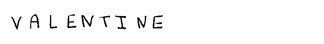

In [42]:
from PIL import Image

img_path = "/kaggle/input/handwriting-recognition/test_v2/test/TEST_0007.jpg"
img = Image.open(img_path)
pred = inference(model, img_path)
print(pred)
img

In [43]:
img_path = "/kaggle/input/handwriting-recognition/test_v2/test/TEST_0006.jpg"
img = Image.open(img_path)
pred = inference(model, img_path)
print(pred)
img

MARIEN


LORRE


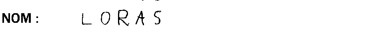

In [44]:
img_path = "/kaggle/input/handwriting-recognition/test_v2/test/TEST_0008.jpg"
img = Image.open(img_path)
pred = inference(model, img_path)
print(pred)
img

MARYANE


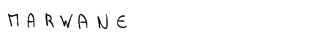

In [47]:
img_path = "/kaggle/input/handwriting-recognition/test_v2/test/TEST_0064.jpg"
img = Image.open(img_path)
pred = inference(model, img_path)
print(pred)
img

**Future Work**

The next step is to test it on a complete handwritten page. The model Implemented above uses words. Since obtaining the words is not the focus of this projct so one way to do this is use the text segmentor implemented and available on https://github.com/harshavkumar/word_segmentation.git.